<div style="float:right">
    <table>
    <tr>
        <td> <img src="../figs/pangeos-small-1.png" alt="PANGEOS" style="width:200px;height:45px;"/> 
        <td> <img src="../figs/kcl_logo.png" alt="King's College London" style="width:54px;height:40px;"/> 
        <td> <img src="../figs/nceo_logo.png" alt="NCEO" style="width:200px;height:40px;"/> 
        <td> <img src="../figs/multiply_logo.png" alt="H2020 Multiply" style="width:40px;height:40px;"/>
    </tr>
    </table>
</div>
&nbsp;





# Inverting Piccolo Doppio spectra using PROSAIL


The idea behind this practical is to allow you to invert reflectance data (plus associated uncertainty) using the PROSAIL model. 


In [33]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from pangeos_uq.param_retrieval import BiophysicalRetrievalInSitu
from pangeos_uq.param_retrieval import get_priors
import matplotlib.pyplot as plt
import seaborn as sns
priors = get_priors()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We have a CSV file that contains data on reflectance and uncertainty ($\sigma$ per wavelength:

In [4]:
df = pd.read_csv("../src/pangeos_uq/data/piccolo_refl.csv")
df.head()

,wl,refl,refl_u
0,401.82374,0.026258,0.000949
1,402.61047,0.026386,0.000954
2,403.39714,0.026713,0.000966
3,404.18373,0.026888,0.000972
4,404.97025,0.027230,0.000984


Let's plot the data and uncertainty...

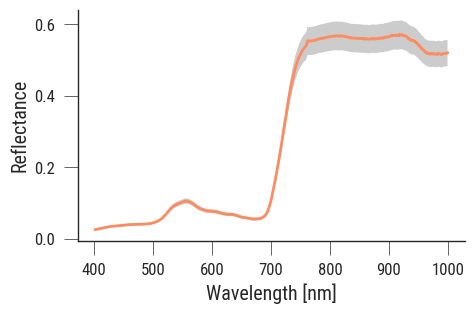

In [21]:
plt.figure(figsize=(5, 3))
plt.plot(df.wl, df.refl, "-")
plt.fill_between(
    df.wl,
    df.refl - 1.95 * df.refl_u,
    df.refl + 1.95 * df.refl_u,
    facecolor="0.8",
)
plt.xlabel("Wavelength [nm]")
plt.ylabel("Reflectance");

In [30]:
# Create the array representing the 400 to 2500 nm range
nm_range = np.linspace(400, 2500, 2101)
wvs = df.wl.to_numpy()
# Create the N x 2101 SRF array
srf = np.zeros((len(wvs), 2101))

# Find the closest index for each wavelength and set that position to 1
closest_indices = np.abs(nm_range[:, None] - wvs).argmin(axis=0)
srf[np.arange(len(wvs)), closest_indices] = 1

priors.keys()

In [36]:


retrieval = BiophysicalRetrievalInSitu(df.refl.to_numpy(),
                                       df.refl_u.to_numpy(),
                                       srf=srf,
                                       sza=30.0,
                                       vza=0,
                                       raa=0,
                                       prior=priors["uniform"],
                                       wvs=wvs,
                                       )

In [39]:
retrieval.run_mcmc(n_samples=20_000)
retrieval.posterior_samples

PARAMETERS_NAME = ['N', 'cab', 'cm', 'cw', 'lai', 'ala', 'cbrown',
                   "psoil", "rsoil"]
posterior_df = pd.DataFrame(retrieval.posterior_samples,
                            columns=PARAMETERS_NAME)

# fig, axes = plt.subplots(n_params, n_params, figsize=(12, 12))
g = sns.kdeplot(
    posterior_df.iloc[-2000::5, :],
    kind="hist",
    diag_kind="hist",
)


Sampling:   0%|          | 0/20000 [00:00<?, ?it/s]

Sampling:   4%|▍         | 822/20000 [00:38<20:11, 15.83it/s]